# VSB Powerline 

tests of different cmap colours and range

using spectrograms created in vsb_powerline_spectrograms

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import glob

In [3]:
from fastai.vision import *

In [4]:
from fastai import *
from fastai.tabular import *
from fastai.utils import *

In [5]:
import fastai
print(fastai.__version__)

1.0.41.dev0


In [6]:
torch.cuda.set_device(0)

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]

In [8]:
DATE

'20190126'

In [9]:
UID

'2b81ea64'

In [10]:
MODEL_NAME='600_cmap_test'

In [11]:
image_size=600
bs = 64
#bs = 16   

In [12]:
path = Path('../input/')

train_path_70_20 = path/'train_600_ts_viridis-70-20/'
train_path_80_20 = path/'train_600_ts_viridis-80-20/'
train_path_110_20 = path/'train_600_ts_viridis-110-20/'
train_path_60_10 = path/'train_600_ts_aug_viridis-60_10/'

In [13]:
train_df = pd.read_csv(path/'metadata_train.csv')

In [14]:
test_df = pd.read_csv(path/'metadata_test.csv')

In [15]:
train_df.tail()

,signal_id,id_measurement,phase,target
8707,8707,2902,1,0
8708,8708,2902,2,0
8709,8709,2903,0,0
8710,8710,2903,1,0
8711,8711,2903,2,0


In [16]:
aug_df = pd.read_csv(path/'metadata_train.csv')

In [17]:
train_files_70_20 = [f for f in listdir(str(train_path_70_20)) if isfile(join(str(train_path_70_20), f))]
train_files_80_20 = [f for f in listdir(str(train_path_80_20)) if isfile(join(str(train_path_80_20), f))]
train_files_110_20 = [f for f in listdir(str(train_path_110_20)) if isfile(join(str(train_path_110_20), f))]
train_files_60_10 = [f for f in listdir(str(train_path_60_10)) if isfile(join(str(train_path_60_10), f))]

In [18]:
train_files_70_20[:10]

['6430.jpg',
 '5197.jpg',
 '8171.jpg',
 '4413.jpg',
 '4913.jpg',
 '3447.jpg',
 '5030.jpg',
 '6521.jpg',
 '2197.jpg',
 '3476.jpg']

#### combine into one dataframe

In [19]:
#not for base model - t/t only and cf 70_20, 60-10 and 110-20
#train_df = pd.concat([train_df, aug_df], ignore_index=True)

In [20]:
len(train_df)

8712

In [21]:
train_df['target'].value_counts()

0    8187
1     525
Name: target, dtype: int64

In [22]:
train_df.head(n=2)

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0


### Validation indexes

In [23]:
df_val = train_df.sample(frac=0.2)
val_idxs=df_val.index.values

### Image Data

In [24]:
#set the random seed so that validation indexes are always the same
np.random.seed(42)

In [25]:
#tfms = get_transforms(do_flip=False, max_rotate=0, max_zoom=0, max_lighting=0.0, max_warp=0)

In [26]:
tfms = get_transforms(do_flip=False, 
                      flip_vert=False, 
                      max_rotate=0., 
                      max_zoom=0., 
                      max_lighting=0., 
                      max_warp=0., 
                      p_affine=0., 
                      p_lighting=0.)

In [27]:
train_df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


### using databunch API

#train_path_70_20 = path/'train_600_ts_viridis-70-20/'


In [28]:
bs=8

In [29]:
data_70_20 = (ImageItemList.from_df(train_df, path=train_path_70_20, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [30]:
#Error when bs <16
#data_70_20.show_batch(rows=2, figsize=(7,6))

## Training: resnet50

In [31]:
learn = create_cnn(data_70_20, models.resnet50, metrics=error_rate)

In [32]:

learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


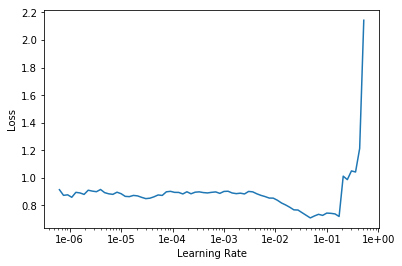

In [34]:
learn.recorder.plot()

In [35]:
#6.094923; slice: 5.992255 	
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.323000,0.139044,0.042480
2,0.195830,1.209486,0.074627
3,0.173250,0.585174,0.058553
4,0.136740,7.174336,0.044776
5,0.098880,5.992255,0.072331


#### cf train_600_ts_viridis-80-20

In [36]:
#train_path_80_20 = path/'train_600_ts_viridis-80-20/'


In [37]:
data_80_20 = (ImageItemList.from_df(train_df, path=train_path_80_20, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [38]:
learn = create_cnn(data_80_20, models.resnet50, metrics=error_rate)

In [39]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


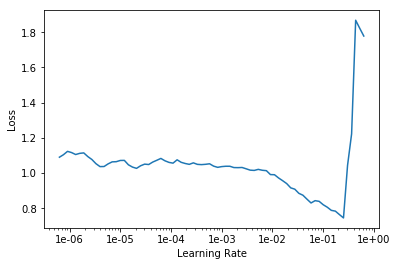

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
#67.440865; 
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.319532,0.132616,0.047646
2,0.242161,0.162877,0.055109
3,0.186137,0.557816,0.058553
4,0.118545,6.951289,0.082664
5,0.141882,0.746360,0.057979


#### cf train_600_ts_viridis-110-20


In [42]:
data_110_20 = (ImageItemList.from_df(train_df, path=train_path_110_20, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [43]:
learn = create_cnn(data_110_20, models.resnet50, metrics=error_rate)

In [44]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


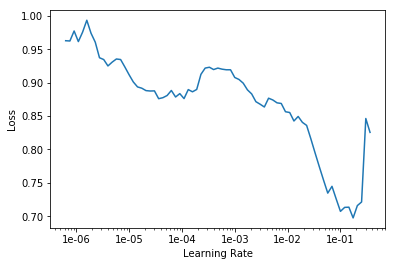

In [45]:
learn.lr_find()
learn.recorder.plot()

In [46]:
#26.425024 	
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.248918,0.297416,0.076923
2,0.254486,0.237601,0.072905
3,0.165523,1.598988,0.054535
4,0.111104,0.319343,0.043054
5,0.094006,1.049022,0.050517


#### cf train_600_ts_aug_viridis-60_10

In [47]:
data_60_10 = (ImageItemList.from_df(train_df, path=train_path_60_10, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [48]:
learn = create_cnn(data_60_10, models.resnet50, metrics=error_rate)

In [49]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


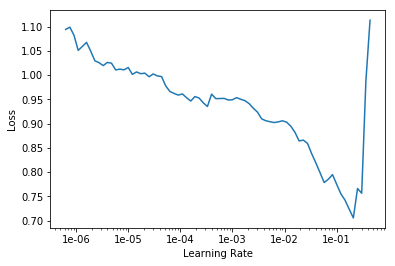

In [50]:
learn.lr_find()
learn.recorder.plot()

In [51]:
#5.509660 	
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.218859,0.146956,0.045924
2,0.200167,3.108242,0.065442
3,0.186705,1.852491,0.060276
4,0.100525,1.714548,0.053961
5,0.107221,0.682932,0.051091


### Repeat

In [52]:
learn = create_cnn(data_70_20, models.resnet50, metrics=error_rate)

In [53]:

learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [54]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


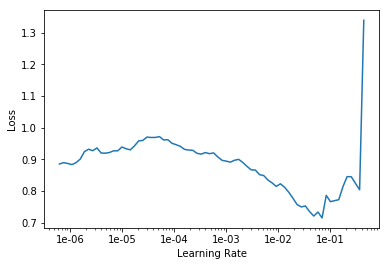

In [55]:
learn.recorder.plot()

In [56]:
#5.603009
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.248907,0.124464,0.046498
2,0.151214,1.090627,0.066590
3,0.130582,1.374472,0.049369
4,0.131498,0.869537,0.045350
5,0.127481,2.035123,0.047072


#### cf train_600_ts_viridis-80-20

In [57]:
#train_path_80_20 = path/'train_600_ts_viridis-80-20/'


In [58]:
data_80_20 = (ImageItemList.from_df(train_df, path=train_path_80_20, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [59]:
learn = create_cnn(data_80_20, models.resnet50, metrics=error_rate)

In [60]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


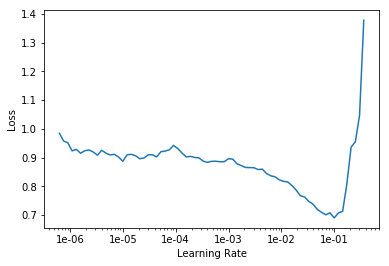

In [61]:
learn.lr_find()
learn.recorder.plot()

In [62]:
#10.694405
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.281045,0.135864,0.048794
2,0.214003,0.399361,0.053961
3,0.144312,1.975466,0.070608
4,0.125220,1.185425,0.057405
5,0.094006,2.839579,0.071183


#### train_600_ts_viridis-110-20

In [63]:
#### cf 
#train_path_110_20 = path/'train_600_ts_viridis-110-20/'


In [64]:
data_110_20 = (ImageItemList.from_df(train_df, path=train_path_110_20, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [65]:
learn = create_cnn(data_110_20, models.resnet50, metrics=error_rate)

In [66]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


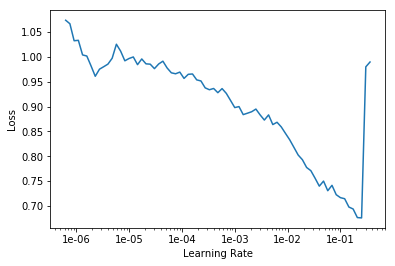

In [67]:
learn.lr_find()
learn.recorder.plot()

In [68]:
#2.278345
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.257303,0.275879,0.059701
2,0.160900,28.081226,0.112514
3,0.177478,14.474843,0.072905
4,0.121962,1.733503,0.035017
5,0.117613,1.633132,0.035591


#### train_600_ts_aug_viridis-60_10

In [69]:
#### test
#train_path_60_10 = path/'train_600_ts_aug_viridis-60_10/'

In [70]:
data_60_10 = (ImageItemList.from_df(train_df, path=train_path_60_10, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [71]:
learn = create_cnn(data_60_10, models.resnet50, metrics=error_rate)

In [72]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


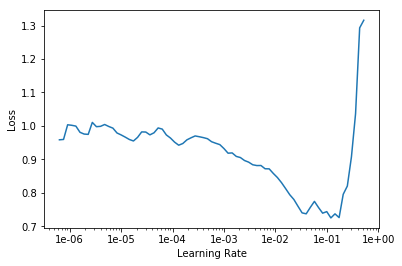

In [73]:
learn.lr_find()
learn.recorder.plot()

In [74]:
#27.776791 	
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.278751,0.229175,0.047646
2,0.194882,0.542849,0.067738
3,0.138083,4.568911,0.085534
4,0.125341,5.777033,0.088978
5,0.094883,1.316202,0.059127


### Repeat

#### train_600_ts_aug_viridis-70_20

In [75]:
learn = create_cnn(data_70_20, models.resnet50, metrics=error_rate)

In [76]:

learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [77]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


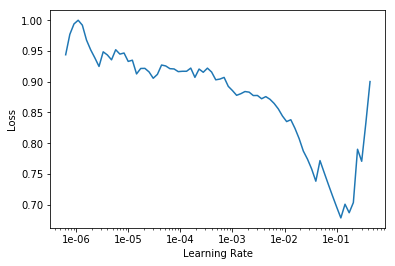

In [78]:
learn.recorder.plot()

In [79]:
#9.664701
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.178151,0.159596,0.043628
2,0.219804,0.270992,0.055683
3,0.143790,2.911065,0.067164
4,0.165049,3.668316,0.072905
5,0.136603,1.665672,0.056257


#### cf train_600_ts_viridis-80-20

In [80]:
#train_path_80_20 = path/'train_600_ts_viridis-80-20/'


In [81]:
data_80_20 = (ImageItemList.from_df(train_df, path=train_path_80_20, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [82]:
learn = create_cnn(data_80_20, models.resnet50, metrics=error_rate)

In [83]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


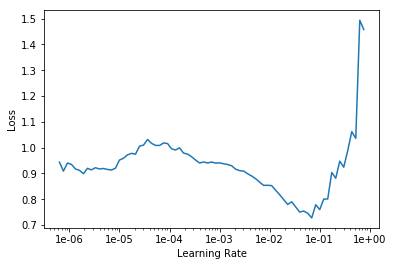

In [84]:
learn.lr_find()
learn.recorder.plot()

In [85]:
#3.706357
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.245701,0.264760,0.049369
2,0.197095,0.808739,0.048794
3,0.202720,0.762645,0.059127
4,0.151426,0.715946,0.060276
5,0.117243,0.427786,0.050517


#### cf train_600_ts_viridis-110-20


In [86]:
data_110_20 = (ImageItemList.from_df(train_df, path=train_path_110_20, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [87]:
learn = create_cnn(data_110_20, models.resnet50, metrics=error_rate)

In [88]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


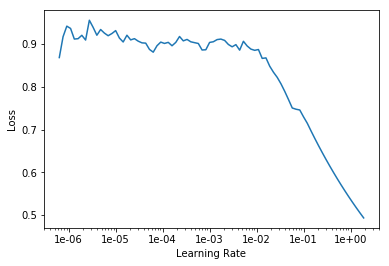

In [89]:
learn.lr_find()
learn.recorder.plot()

In [90]:
#4.187525
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.240909,0.183217,0.051665
2,0.190024,0.295680,0.041906
3,0.200762,1.347650,0.067738
4,0.106204,0.685230,0.045350
5,0.100711,0.338879,0.039036


#### cf train_600_ts_aug_viridis-60_10

In [91]:
data_60_10 = (ImageItemList.from_df(train_df, path=train_path_60_10, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [92]:
learn = create_cnn(data_60_10, models.resnet50, metrics=error_rate)

In [93]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


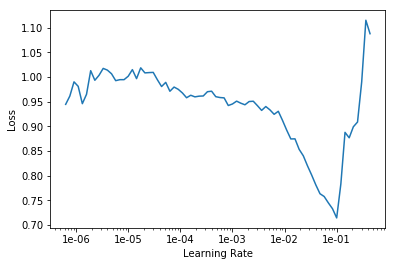

In [94]:
learn.lr_find()
learn.recorder.plot()

In [95]:
#14.362915
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.284161,0.131724,0.047646
2,0.172542,1.067554,0.048794
3,0.203619,5.160779,0.068312
4,0.138194,16.283134,0.054535
5,0.086047,14.208296,0.052239


### Repeat (slice)

#### 70-20

In [96]:
learn = create_cnn(data_70_20, models.resnet50, metrics=error_rate)

In [97]:

learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

In [98]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


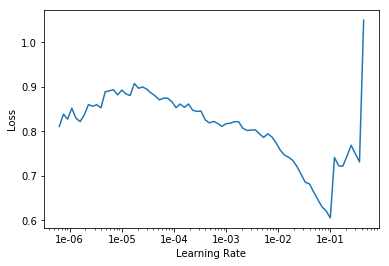

In [99]:
learn.recorder.plot()

In [100]:
#0.369796; slice 4.632230
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.192438,0.133194,0.041906
2,0.246308,1.470436,0.064868
3,0.184586,5.153977,0.055109
4,0.154571,1.437527,0.055109
5,0.139133,0.649029,0.044776


#### cf train_600_ts_viridis-80-20

In [101]:
#train_path_80_20 = path/'train_600_ts_viridis-80-20/'


In [102]:
data_80_20 = (ImageItemList.from_df(train_df, path=train_path_80_20, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [103]:
learn = create_cnn(data_80_20, models.resnet50, metrics=error_rate)

In [104]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


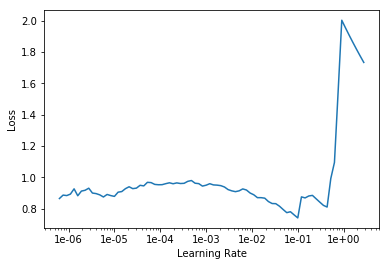

In [105]:
learn.lr_find()
learn.recorder.plot()

In [106]:
#15.048810; slice 9.146284
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.176144,0.264634,0.053961
2,0.236962,0.382797,0.052239
3,0.195157,1.019123,0.064294
4,0.127586,0.622971,0.043054
5,0.098066,1.255553,0.056257


#### cf train_600_ts_viridis-110-20


In [107]:
data_110_20 = (ImageItemList.from_df(train_df, path=train_path_110_20, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [108]:
learn = create_cnn(data_110_20, models.resnet50, metrics=error_rate)

In [109]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


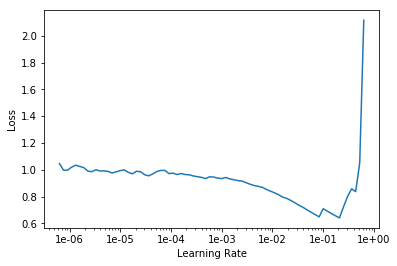

In [110]:
learn.lr_find()
learn.recorder.plot()

In [111]:
#39.936691; slice 5.279502
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.181746,0.206123,0.051665
2,0.191197,0.137542,0.040758
3,0.133397,0.326491,0.059701
4,0.139624,1.072549,0.049943
5,0.131195,0.238576,0.036165


####  cf train_600_ts_aug_viridis-60_10

In [112]:
data_60_10 = (ImageItemList.from_df(train_df, path=train_path_60_10, cols='signal_id', suffix=".jpg")
        .split_by_idx(val_idxs)
        .label_from_df(cols='target')
        .transform(tfms, size=image_size)
        .databunch(bs=bs))

In [113]:
learn = create_cnn(data_60_10, models.resnet50, metrics=error_rate)

In [114]:
learn.model = torch.nn.DataParallel(learn.model, device_ids=[0,1])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


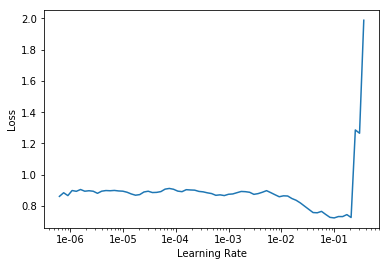

In [115]:
learn.lr_find()
learn.recorder.plot()

In [116]:
#5.999773; slice: 0.194779
learn.fit_one_cycle(5, slice(1e-2))

epoch,train_loss,valid_loss,error_rate
1,0.230564,0.223071,0.050517
2,0.214189,0.379618,0.043054
3,0.151717,1.650089,0.048794
4,0.118271,8.376352,0.059127
5,0.144026,3.005290,0.048220


### Results

![title](results/cmap_600_performance.png)

range -70 to 20 most consistent (at 1 epoch at lr slice(1e-2))